In [1]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))

In [2]:
import argparse
import torch
from torch import nn
import matplotlib.pyplot as plt
from stu import STU
import time
import random
import numpy as np

Unable to import FlashFFTConv: No module named 'flashfftconv'. Falling back to PyTorch implementation.


In [3]:
from lds import LDS

In [4]:
def get_hankel(seq_len: int, use_hankel_L: bool = False) -> np.ndarray:
    entries = np.arange(1, seq_len + 1, dtype=np.float64)
    i_plus_j = entries[:, None] + entries[None, :]

    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    elif not use_hankel_L:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    else:
        raise ValueError("use_hankel_L must be a boolean")

    return Z

def get_spectral_filters(
    seq_len: int,
    K: int,
    use_hankel_L: bool = False,
    device: torch.device = None,
    dtype: torch.dtype = torch.bfloat16,
) -> torch.Tensor:
    # assert torch.cuda.is_available(), "CUDA is required."
    Z = get_hankel(seq_len, use_hankel_L)
    sigma, phi = np.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    filters = torch.from_numpy(phi_k)
    return filters.to(device=device, dtype=dtype)


In [5]:
layer_i = 0
state_dim = 10000
batch_size = 2
epochs = 4000
seq_len = 512
kx = 5
lr = 0.0001

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_len = 4096
num_eigh = 30
use_hankel_L  = True
phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L,
                                device  = device,  dtype = torch.float32)

stu_config = {
    "num_eigh": num_eigh,
    "use_hankel_L": True,
    "torch_dtype": torch.float32,
    "d_in": 1,
    "d_out": 1,
    "seq_len": seq_len,
    "k_u": 0
}


In [6]:
# Initialize LDS model
lds = LDS(state_dim, 768, 768, kx).to(device)
optimizer = torch.optim.Adam(lds.parameters(), lr=lr)

# Training
lds_loss_values = []

best_loss = float('inf')

In [7]:
from basic_stu import STU

In [8]:
phi_0 = STU(stu_config, phi).to(device)

In [9]:
phi_0.M_phi_minus.data = torch.zeros_like(phi_0.M_phi_minus)
phi_0.M_phi_plus.data = torch.zeros_like(phi_0.M_phi_plus)

In [10]:
phi_0.M_phi_plus[0][0][0].data = torch.tensor(1.0, requires_grad= True)

In [11]:
for epoch in range(epochs):
    inputs = torch.randn(batch_size, seq_len, 768).to(device).to(torch.bfloat16)
    stu_outputs = phi_0(inputs).to(device)

    optimizer.zero_grad()
    loss = lds.compute_loss(inputs.to(stu_outputs.dtype), stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lds.parameters(), max_norm=1)
    lds_loss_values.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        lds.A.data.clamp_(max=1, min=-1)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

/opt/homebrew/anaconda3/envs/flashstu/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2, 4096, 1])) that is different to the input size (torch.Size([2, 4096, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.006508288439363241
Epoch 10, Loss: 0.0016739849233999848
Epoch 20, Loss: 0.00043844940955750644
Epoch 30, Loss: 0.00019047182286158204
Epoch 40, Loss: 8.755858289077878e-05
Epoch 50, Loss: 3.903612741851248e-05
Epoch 60, Loss: 2.0163486624369398e-05


KeyboardInterrupt: 

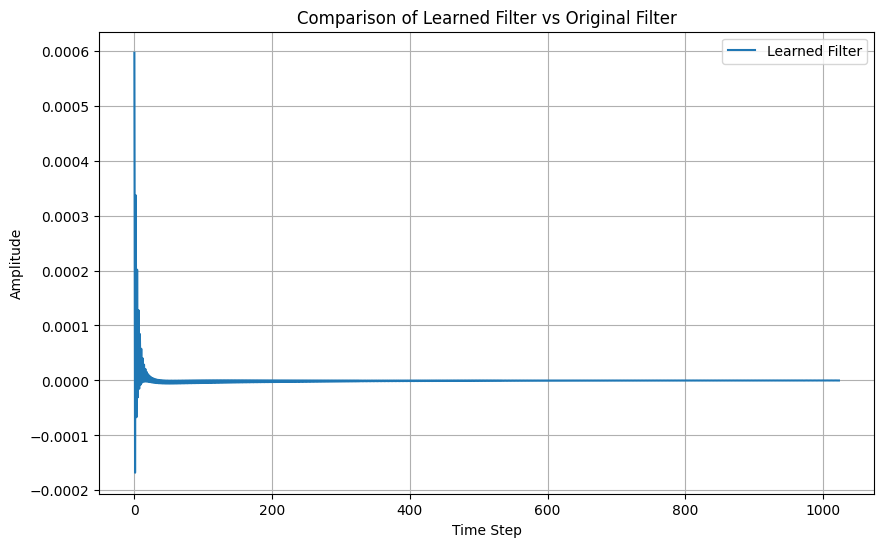

In [ ]:
# Get the learned impulse response
learned_impulse = lds.impulse().cpu().detach().numpy()

# Get the original filter phi
original_phi = phi.cpu().numpy()[:, 0]  # Taking first filter for comparison

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(learned_impulse, label='Learned Filter')
plt.plot(original_phi, label='Original Filter (phi)')
plt.title('Comparison of Learned Filter vs Original Filter')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


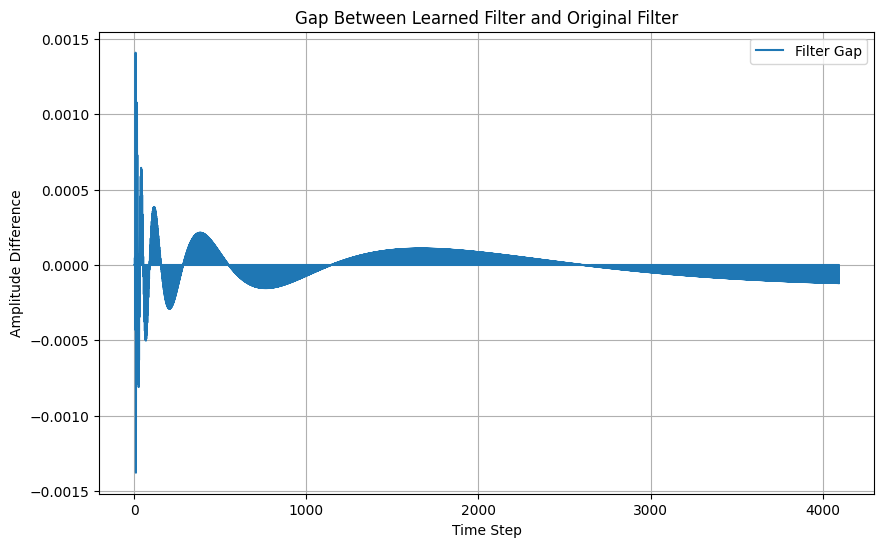

In [14]:
# Calculate the difference between learned and original filters
filter_gap = learned_impulse[512] - original_phi

plt.figure(figsize=(10, 6))
plt.plot(filter_gap, label='Filter Gap')
plt.title('Gap Between Learned Filter and Original Filter')
plt.xlabel('Time Step')
plt.ylabel('Amplitude Difference')
plt.legend()
plt.grid(True)
plt.show()
